In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from plotnine import *

In [2]:
d = pd.read_csv('rank_runs_summary.csv')

d

,example_name,estimate_name,SpearmanR_all,SpearmanR_test,pick_auc,data_size,test_size,run_i,rand_seed
0,uci wine example,Stan panel model,0.419539,0.419711,0.856750,6497,6017,0,518677876
1,uci wine example,logistic model,0.435503,0.436348,0.848788,6497,6017,0,518677876
2,uci wine example,Stan comparisons model,0.426145,0.426784,0.856738,6497,6017,0,518677876
3,uci wine example,observed score,0.500823,0.499834,0.846475,6497,6017,0,518677876
4,uci wine example,Stan panel model,0.387950,0.383969,0.886875,6497,6025,1,1451336747
...,...,...,...,...,...,...,...,...,...
75,uci wine example,observed score,0.522425,0.520198,0.873463,6497,6015,18,566571108
76,uci wine example,Stan panel model,0.446998,0.447564,0.869125,6497,6014,19,364254565
77,uci wine example,logistic model,0.455365,0.454713,0.866813,6497,6014,19,364254565
78,uci wine example,Stan comparisons model,0.456367,0.455968,0.870325,6497,6014,19,364254565


In [3]:
n_draws = int(np.max(d['run_i']) + 1)

In [4]:
d_SpearmanR = d.melt(
    id_vars=['example_name', 'estimate_name'],
    value_vars=['SpearmanR_all', 'SpearmanR_test'],
    var_name='measurement',
    value_name='Spearman R',
)

d_SpearmanR

,example_name,estimate_name,measurement,Spearman R
0,uci wine example,Stan panel model,SpearmanR_all,0.419539
1,uci wine example,logistic model,SpearmanR_all,0.435503
2,uci wine example,Stan comparisons model,SpearmanR_all,0.426145
3,uci wine example,observed score,SpearmanR_all,0.500823
4,uci wine example,Stan panel model,SpearmanR_all,0.387950
...,...,...,...,...
155,uci wine example,observed score,SpearmanR_test,0.520198
156,uci wine example,Stan panel model,SpearmanR_test,0.447564
157,uci wine example,logistic model,SpearmanR_test,0.454713
158,uci wine example,Stan comparisons model,SpearmanR_test,0.455968


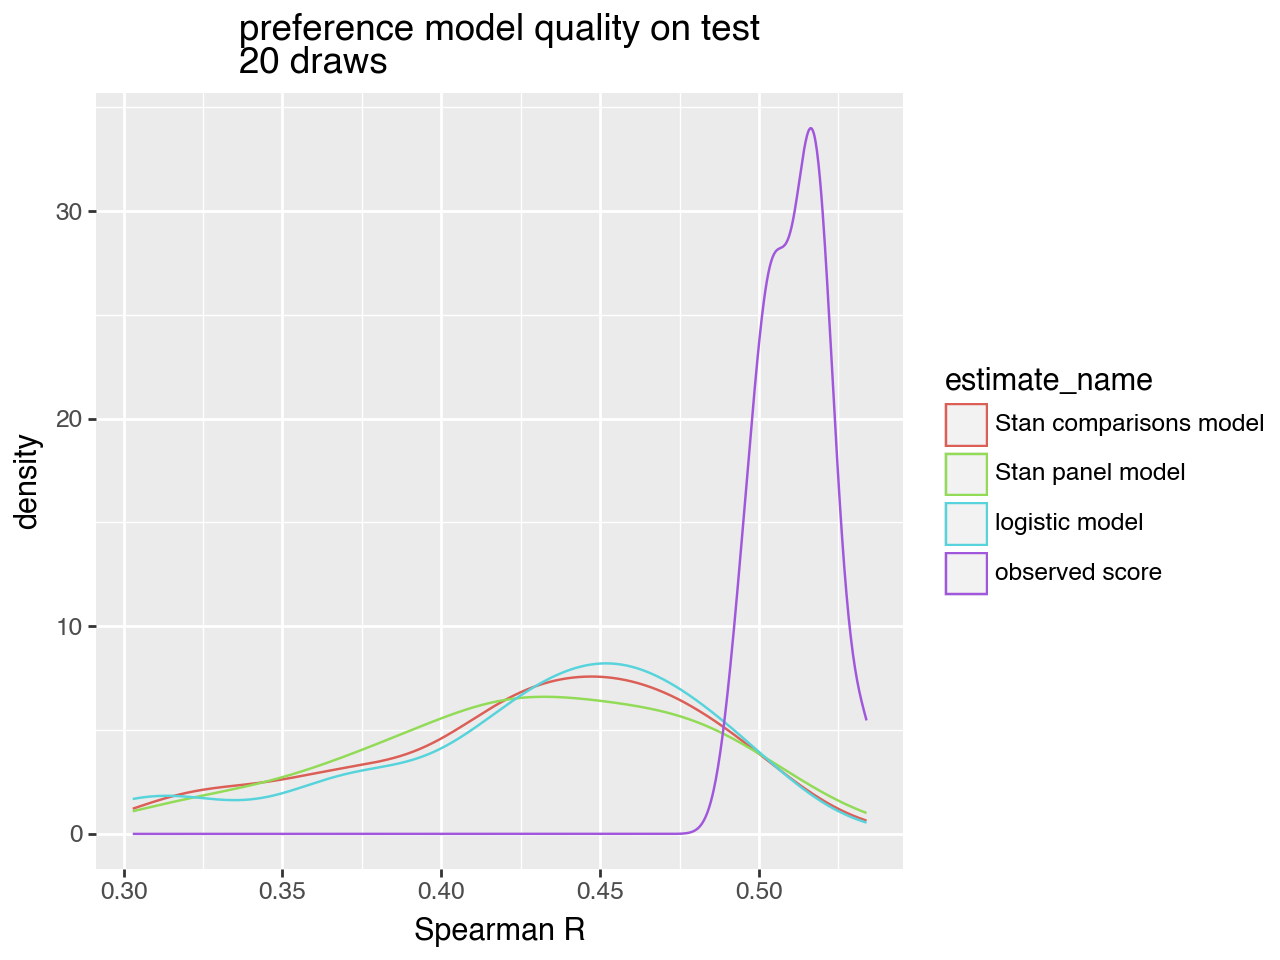

In [5]:
(
    ggplot(
        data=d_SpearmanR.loc[d_SpearmanR['measurement'] == 'SpearmanR_test', :],
        mapping=aes(
            x='Spearman R',
            color='estimate_name',
        )
    )
    + geom_density()
    + ggtitle(f"preference model quality on test\n{n_draws} draws")
)

In [6]:
estimate_names = sorted(set(d['estimate_name']))

estimate_names

['Stan comparisons model',
 'Stan panel model',
 'logistic model',
 'observed score']

Stan comparisons model


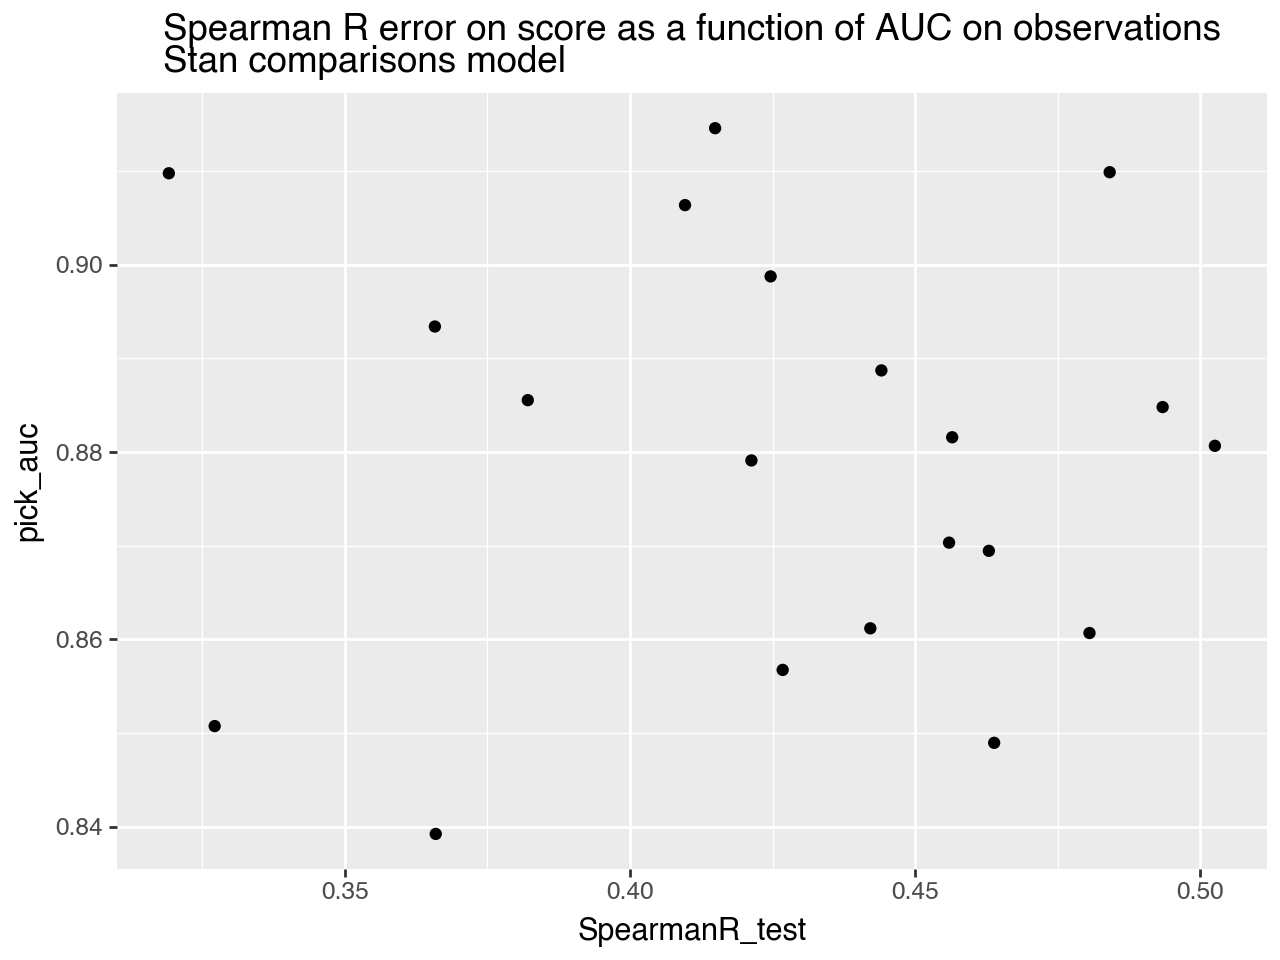

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         SpearmanR_test   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.055
Method:                 Least Squares   F-statistic:                   0.01454
Date:                Mon, 26 Aug 2024   Prob (F-statistic):              0.905
Time:                        08:05:31   Log-Likelihood:                 31.012
No. Observations:                  20   AIC:                            -58.02
Df Residuals:                      18   BIC:                            -56.03
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4867      0.494      0.985      0.338      -0.551       1.525
pick_auc      -0.0677      0.561     -0.121      0.905      -1.247       1.112
==============================================================================
Omnibus:                        1.703   Durbin-Watson:                   1.316
Prob(Omnibus):                  0.427   Jarque-Bera (JB):                1.413
Skew:                          -0.598   Prob(JB):                        0.493
Kurtosis:                       2.484   Cond. No.                         82.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Stan panel model


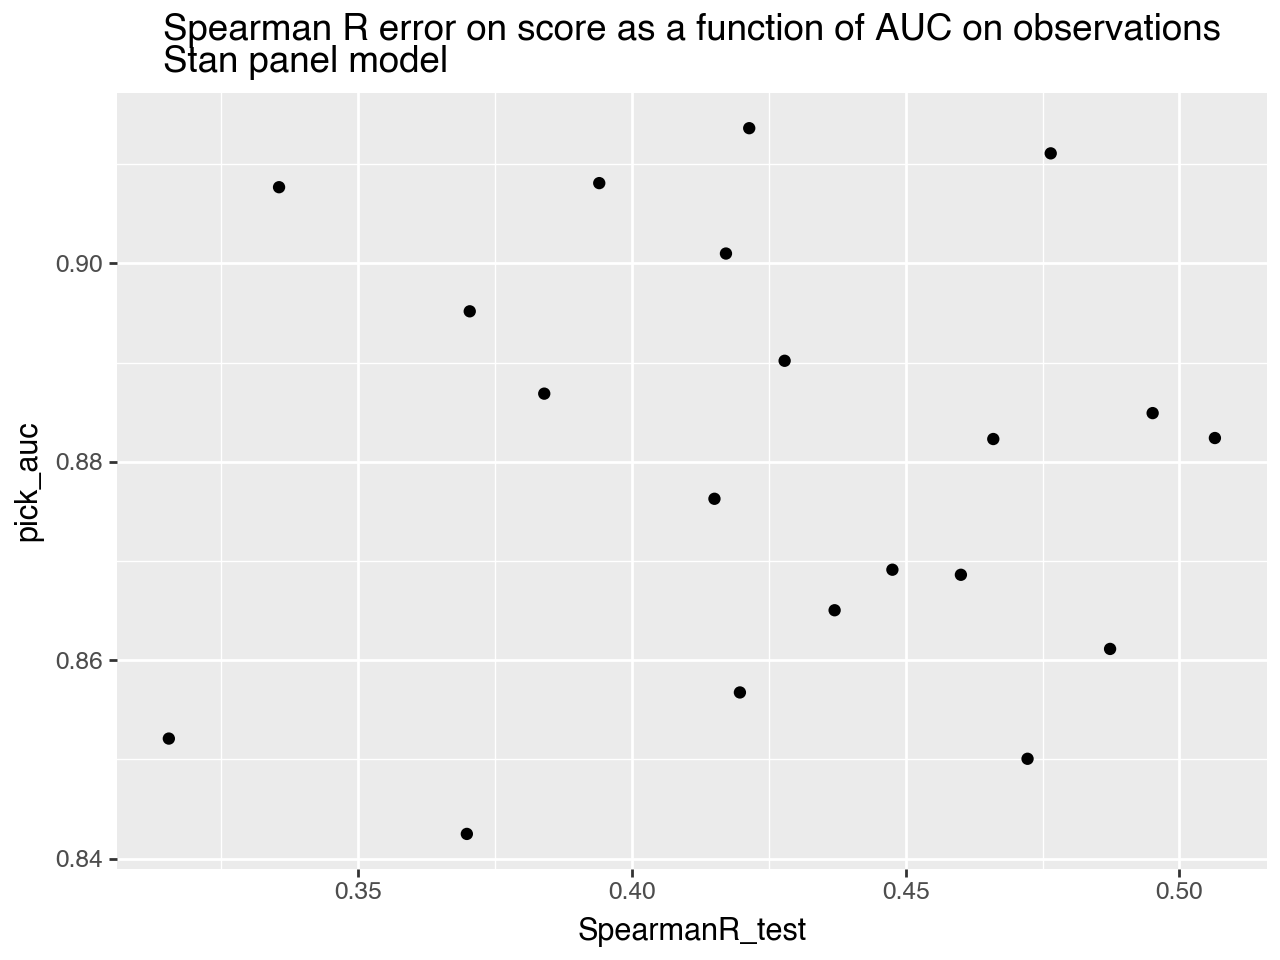

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         SpearmanR_test   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.055
Method:                 Least Squares   F-statistic:                   0.01423
Date:                Mon, 26 Aug 2024   Prob (F-statistic):              0.906
Time:                        08:05:31   Log-Likelihood:                 31.005
No. Observations:                  20   AIC:                            -58.01
Df Residuals:                      18   BIC:                            -56.02
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4859      0.503      0.966      0.347      -0.571       1.543
pick_auc      -0.0682      0.571     -0.119      0.906      -1.268       1.132
==============================================================================
Omnibus:                        0.927   Durbin-Watson:                   1.249
Prob(Omnibus):                  0.629   Jarque-Bera (JB):                0.865
Skew:                          -0.428   Prob(JB):                        0.649
Kurtosis:                       2.447   Cond. No.                         83.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

logistic model


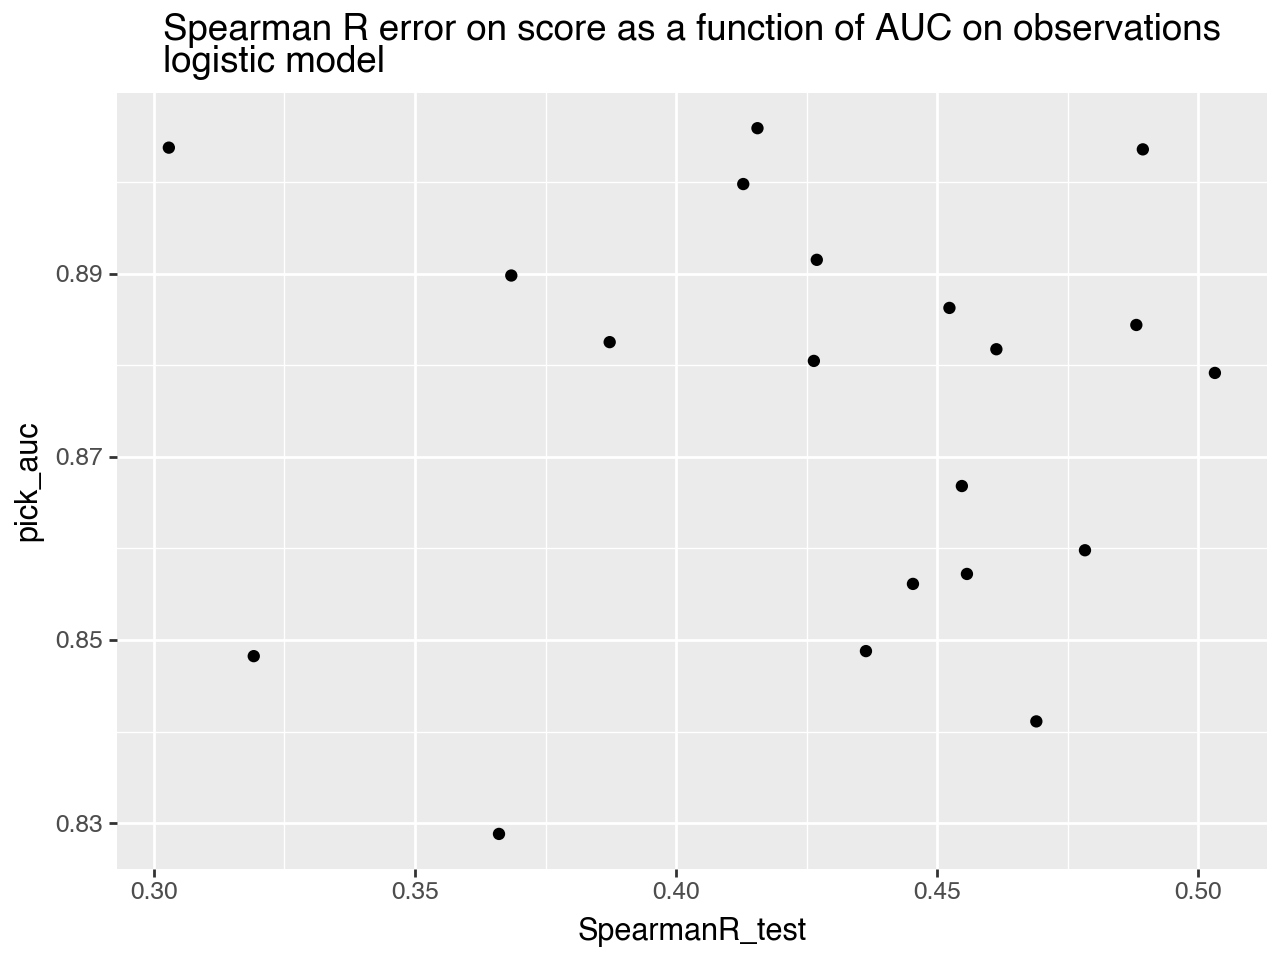

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         SpearmanR_test   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.056
Method:                 Least Squares   F-statistic:                 0.0002041
Date:                Mon, 26 Aug 2024   Prob (F-statistic):              0.989
Time:                        08:05:32   Log-Likelihood:                 30.098
No. Observations:                  20   AIC:                            -56.20
Df Residuals:                      18   BIC:                            -54.20
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4351      0.503      0.866      0.398      -0.621       1.491
pick_auc      -0.0082      0.574     -0.014      0.989      -1.215       1.199
==============================================================================
Omnibus:                        3.385   Durbin-Watson:                   1.393
Prob(Omnibus):                  0.184   Jarque-Bera (JB):                2.340
Skew:                          -0.837   Prob(JB):                        0.310
Kurtosis:                       2.918   Cond. No.                         80.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

observed score


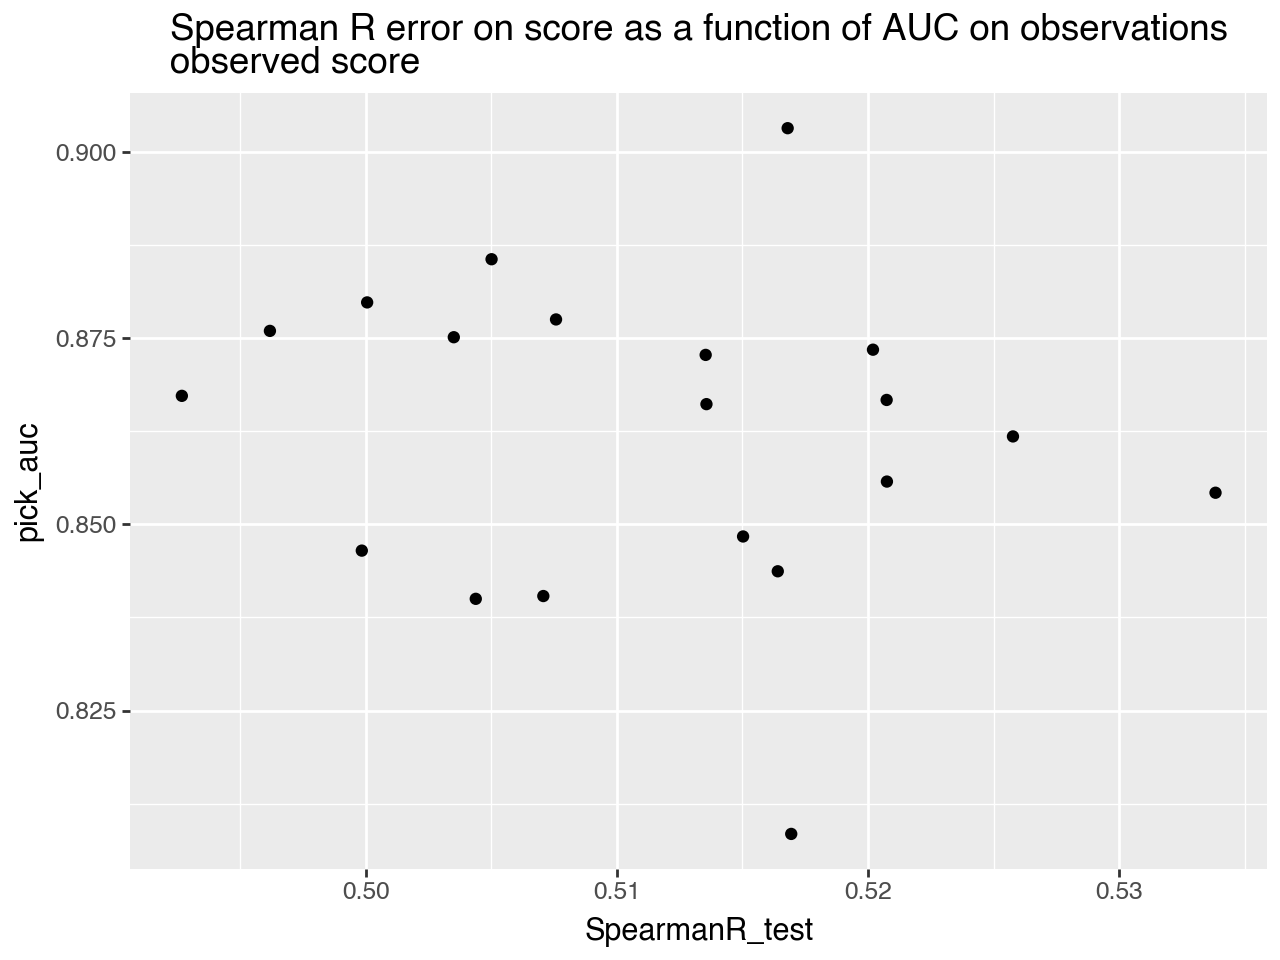

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         SpearmanR_test   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                 -0.028
Method:                 Least Squares   F-statistic:                    0.4888
Date:                Mon, 26 Aug 2024   Prob (F-statistic):              0.493
Time:                        08:05:32   Log-Likelihood:                 63.498
No. Observations:                  20   AIC:                            -123.0
Df Residuals:                      18   BIC:                            -121.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5825      0.102      5.731      0.000       0.369       0.796
pick_auc      -0.0824      0.118     -0.699      0.493      -0.330       0.165
==============================================================================
Omnibus:                        0.188   Durbin-Watson:                   2.303
Prob(Omnibus):                  0.910   Jarque-Bera (JB):                0.386
Skew:                           0.129   Prob(JB):                        0.824
Kurtosis:                       2.370   Cond. No.                         86.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
for estimate_name in estimate_names:
    di = d.loc[d['estimate_name'] == estimate_name, :]
    print(estimate_name)
    (
        ggplot(
            data=di,
            mapping=aes(x='SpearmanR_test', y='pick_auc')
        )
        + geom_point()
        + ggtitle(f"Spearman R error on score as a function of AUC on observations\n{estimate_name}")
    ).show()
    model = ols(
        'SpearmanR_test ~ pick_auc',
        data=di,
    ).fit()
    display(model.summary())